# Reinforcement Learning Portfolio Optimization 

# Project scope & deliverables

**Goal**: 
- Train a PPO‑LSTM trading agent that learns dynamic, risk‑aware strategies on 50+ ETFs and generalizes across markets (stocks/forex/ETFs/crypto-like OHLCV).

**MVP features**:
- Custom Gymnasium environment for multi‑asset trading with buy/sell/hold, 10% per‑trade cap, position tracking, P&L, tax simulation, transaction costs, slippage, trade log.
- Data pipeline from Yahoo Finance (historical OHLCV/Adj Close) with leak‑proof feature engineering.
- Train/evaluate RecurrentPPO (PPO‑LSTM); compare to strong baselines.
- Rich evaluation: metrics, benchmarks (SPY), visual dashboards (grid plots), reproducibility.

**Stretch**: 
- allocation‑mode policy (weight targets), walk‑forward validation with purged/embargoed CV, transaction‑cost sensitivity, ablation studies.

# Understanding Data

In [6]:
#pip install sb3_contrib
#!pip install gym
#!pip install "stable-baselines3[extra]==2.3.0" "sb3-contrib==2.3.0" gymnasium shimmy>=2.0
# !pip install sb3_contrib
# !pip install stable-baselines3[extra] sb3-contrib

In [7]:
# --- Silence TensorFlow/CUDA chatter (we're using PyTorch for SB3) ---
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"   # silence TF logs

# --- Ensure compatible versions are present (Gymnasium 0.29 + SB3 2.3 + sb3-contrib 2.3) ---
import sys, subprocess, pkgutil

def need(pkg_name: str) -> bool:
    base = pkg_name.split("==")[0].split("[")[0]
    return pkgutil.find_loader(base) is None

def pip_install(spec: str):
    subprocess.check_call([sys.executable, "-m", "pip", "install", spec, "-q"])

# Pin a compatible trio. If these are already installed, this is a no-op.
if need("stable_baselines3"):
    pip_install("stable-baselines3[extra]==2.3.0")
if need("sb3_contrib"):
    pip_install("sb3-contrib==2.3.0")
# Gymnasium 0.29.x is what SB3 2.3 expects
try:
    import gymnasium as gym
    import importlib.metadata as md
    if tuple(int(x) for x in md.version("gymnasium").split(".")[:2]) != (0, 29):
        pip_install("gymnasium==0.29.1")
except Exception:
    pip_install("gymnasium==0.29.1")

# Optional: if your environment has NumPy 2.x and you see incompatibilities, uncomment:
# pip_install("numpy<2.0")

# --- Verify imports now work ---
import gymnasium as gym
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from sb3_contrib import RecurrentPPO

print("Imports OK:",
      "gymnasium", gym.__version__,
      "| sb3 OK | sb3-contrib OK")


Reason for being yanked: Loading broken with PyTorch 1.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
langchain 0.1.20 requires numpy<2,>=1, but you have numpy 2.2.6 which is incompatible.
langchain-community 0.0.38 requires numpy<2,>=1, but you have numpy 2.2.6 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.2.6 which is incompatible.
pyautogen 0.2.29 requires numpy<2,>=1.17.0, but you have numpy 2.2.6 which is incompatible.
pygwalker 0.4.9.13 requires numpy<2.0.0, but you have numpy 2.2.6 which is incompatible.
quantstats 0.0.64 requires numpy<2.0.0,>=1.21.0, but you have numpy 2.2.6 which is incompatible.
scikit-learn 1.4.1.post1 requires n

Imports OK: gymnasium 0.29.1 | sb3 OK | sb3-contrib OK


In [8]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from textwrap import dedent
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from sb3_contrib import RecurrentPPO


In [9]:
# ---- 1. load data
df = pd.read_csv('etf_data.csv')
df.head()

,Date,Ticker,Open,High,Low,Close,Volume
0,2005-01-03,AGG,53.444189,53.553859,53.329303,53.475525,479600.0
1,2005-01-03,DIA,68.327229,68.605210,67.556454,67.802849,11691300.0
2,2005-01-03,DVY,29.630455,29.635253,29.088141,29.131334,768900.0
3,2005-01-03,EEM,14.915271,14.970731,14.743712,14.771072,4275000.0
4,2005-01-03,EFA,29.678428,29.735861,29.420902,29.476482,5273700.0


In [10]:
# ---- 2. Data Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433838 entries, 0 to 433837
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    433838 non-null  object 
 1   Ticker  433838 non-null  object 
 2   Open    433838 non-null  float64
 3   High    433838 non-null  float64
 4   Low     433838 non-null  float64
 5   Close   433838 non-null  float64
 6   Volume  433838 non-null  float64
dtypes: float64(5), object(2)
memory usage: 23.2+ MB


In [11]:
# ---- 3. quick checks
print("\nBASIC SHAPE & COLUMNS")
print(df.shape)
print(df.columns.tolist())


BASIC SHAPE & COLUMNS
(433838, 7)
['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']


In [12]:
# ---- 4. Check Date Range
print("\nDATE RANGE")
print("Start:", df["Date"].min(), " End:", df["Date"].max())


DATE RANGE
Start: 2005-01-03  End: 2025-08-15


In [13]:
# ---- 5. Number of Tickers
print("\n# UNIQUE TICKERS")
print(df["Ticker"].nunique())


# UNIQUE TICKERS
98


In [14]:
# ---- 6. Per-ticker coverage range
# start/end dates & row counts per ticker (easy to read)
coverage = (
    df.groupby("Ticker")["Date"]
      .agg(Start="min", End="max", Rows="count")
      .reset_index()
      .sort_values("Ticker")
)
print("\nCOVERAGE (first 10 rows)")
coverage.head()


COVERAGE (first 10 rows)


,Ticker,Start,End,Rows
0,ACWI,2008-03-28,2025-08-15,4375
1,AGG,2005-01-03,2025-08-15,5188
2,BIL,2007-05-30,2025-08-15,4584
3,BIV,2007-04-10,2025-08-15,4619
4,BND,2007-04-10,2025-08-15,4619


In [15]:
# ---- 7. Feature Engineering

# daily simple returns by ticker
df["Ret"] = df.groupby("Ticker")["Close"].pct_change()

# dollar volume (rough liquidity proxy)
df["DollarVol"] = df["Close"] * df["Volume"]

In [16]:
df.head()

,Date,Ticker,Open,High,Low,Close,Volume,Ret,DollarVol
0,2005-01-03,AGG,53.444189,53.553859,53.329303,53.475525,479600.0,NaN,2.564686e+07
1,2005-01-03,DIA,68.327229,68.605210,67.556454,67.802849,11691300.0,NaN,7.927034e+08
2,2005-01-03,DVY,29.630455,29.635253,29.088141,29.131334,768900.0,NaN,2.239908e+07
3,2005-01-03,EEM,14.915271,14.970731,14.743712,14.771072,4275000.0,NaN,6.314633e+07
4,2005-01-03,EFA,29.678428,29.735861,29.420902,29.476482,5273700.0,NaN,1.554501e+08


In [17]:
# starting from your long df
df = pd.read_csv('etf_data.csv')

# start from your long df with columns: Date, Ticker, Open, High, Low, Close, Volume
df['Date'] = pd.to_datetime(df['Date'])

# 1) Pivot (field, ticker) -> rows are dates
wide = df.pivot(index='Date', columns='Ticker', values=['Open','High','Low','Close','Volume'])

# 2) Put Ticker first, Field second
wide = wide.swaplevel(0, 1, axis=1)

# 3) Reindex the field level to the desired order within each ticker
field_order = ['Open', 'High', 'Low', 'Close', 'Volume']
tickers = wide.columns.levels[0]
wide = wide.reindex(columns=pd.MultiIndex.from_product([tickers, field_order]))

# 4) Flatten to Ticker_Field and tidy up
wide.columns = [f"{tic}_{fld}" for (tic, fld) in wide.columns]
stock_data = wide.sort_index().ffill()

print(stock_data.columns[:15])
print(stock_data.shape)

stock_data.head(100)


Index(['ACWI_Open', 'ACWI_High', 'ACWI_Low', 'ACWI_Close', 'ACWI_Volume',
       'AGG_Open', 'AGG_High', 'AGG_Low', 'AGG_Close', 'AGG_Volume',
       'BIL_Open', 'BIL_High', 'BIL_Low', 'BIL_Close', 'BIL_Volume'],
      dtype='object')
(5188, 490)


,ACWI_Open,ACWI_High,ACWI_Low,ACWI_Close,ACWI_Volume,AGG_Open,AGG_High,AGG_Low,AGG_Close,AGG_Volume,BIL_Open,BIL_High,BIL_Low,BIL_Close,BIL_Volume,BIV_Open,BIV_High,BIV_Low,BIV_Close,BIV_Volume,BND_Open,BND_High,BND_Low,BND_Close,BND_Volume,BNDX_Open,BNDX_High,BNDX_Low,BNDX_Close,BNDX_Volume,BSV_Open,BSV_High,BSV_Low,BSV_Close,BSV_Volume,COWZ_Open,COWZ_High,COWZ_Low,COWZ_Close,COWZ_Volume,...,VXF_Open,VXF_High,VXF_Low,VXF_Close,VXF_Volume,VXUS_Open,VXUS_High,VXUS_Low,VXUS_Close,VXUS_Volume,VYM_Open,VYM_High,VYM_Low,VYM_Close,VYM_Volume,XLE_Open,XLE_High,XLE_Low,XLE_Close,XLE_Volume,XLF_Open,XLF_High,XLF_Low,XLF_Close,XLF_Volume,XLK_Open,XLK_High,XLK_Low,XLK_Close,XLK_Volume,XLV_Open,XLV_High,XLV_Low,XLV_Close,XLV_Volume,XLY_Open,XLY_High,XLY_Low,XLY_Close,XLY_Volume
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,53.444189,53.553859,53.329303,53.475525,479600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.731327,31.731327,31.112740,31.131830,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.229938,20.285978,19.602306,19.602306,3981600.0,16.512841,16.534321,16.314151,16.335630,5011647.0,16.365720,16.388802,16.081031,16.104115,1323900.0,21.526911,21.526911,21.081525,21.095665,606200.0,27.426466,27.503832,27.109263,27.124737,429200.0
2005-01-04,NaN,NaN,NaN,NaN,NaN,53.506855,53.527744,53.303189,53.423302,190500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.158554,31.215831,30.555238,30.623970,31000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.725590,19.809646,19.490226,19.501434,6333300.0,16.405439,16.432289,16.147677,16.179897,7426746.0,16.142595,16.211843,15.742492,15.804048,764700.0,21.194637,21.244124,20.834088,20.925993,454300.0,27.124723,27.240771,26.761099,26.807520,845100.0
2005-01-05,NaN,NaN,NaN,NaN,NaN,53.371042,53.449376,53.297931,53.402378,69900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.547614,30.547614,30.207772,30.276505,34000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.501436,19.641533,19.366945,19.417379,3974000.0,16.163791,16.287301,16.147681,16.153049,2943321.0,15.811745,15.957937,15.750191,15.750191,813500.0,20.911859,21.024972,20.883581,20.890650,448300.0,26.923569,26.923569,26.706944,26.706944,130300.0
2005-01-06,NaN,NaN,NaN,NaN,NaN,53.418022,53.459801,53.360577,53.438911,75400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.261226,30.486513,30.261226,30.364323,94200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.361344,19.899314,19.355741,19.753614,5028800.0,16.196015,16.281936,16.179905,16.233604,3211925.0,15.780959,15.865596,15.696321,15.704016,481700.0,20.996686,21.123938,20.890641,21.046173,1247500.0,26.676005,26.730161,26.559956,26.567692,129200.0
2005-01-07,NaN,NaN,NaN,NaN,NaN,53.470300,53.496412,53.324078,53.423302,137000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.433041,30.433041,30.123748,30.238302,59200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.837661,19.837661,19.422975,19.596695,4722900.0,16.298039,16.298039,16.147678,16.147678,1519670.0,15.696325,15.865600,15.650160,15.734797,395600.0,21.102730,21.138078,21.003755,21.032034,173600.0,26.699219,26.699219,26.451646,26.559961,215000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-19,NaN,NaN,NaN,NaN,NaN,54.105458,54.131899,53.957399,54.068443,64200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [18]:
# Basic data sanitization (do this right after you create stock_data)
import numpy as np
import pandas as pd

# Replace Inf with NaN, then forward/back fill within each column
stock_data = stock_data.replace([np.inf, -np.inf], np.nan)
stock_data = stock_data.ffill().bfill()

# If any dates still have missing values for any ticker, drop those dates (safe & simple)
stock_data = stock_data.dropna(how="any")

# Optional: enforce non-negative prices/volumes
for col in stock_data.columns:
    stock_data[col] = stock_data[col].clip(lower=0)

print("After cleaning:", stock_data.shape, "NaNs left:", stock_data.isna().sum().sum())


After cleaning: (5188, 490) NaNs left: 0


# Trading Environment

In [19]:
# ============================== #
#   PortfolioEnvV3 (completed)   #
# ============================== #
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

SHORT_TERM_TAX_RATE = 0.20
LONG_TERM_TAX_RATE  = 0.15
HOLDING_PERIOD_DAYS = 365


class PortfolioEnvV3(gym.Env):
    """
    Multi-asset, daily-bar environment (wide OHLCV).
    Reward_t = w_ret*ret_t + w_sharpe*(ret_t / (eps+ewm_vol_t))
               - dd_lambda * max(0, DD_t - DD_{t-1})
               - turnover_lambda * (turnover_t / NAV_{t-1})
               - churn_lambda * |Δshares|_1
    Actions per asset: 0=HOLD, 1=BUY, 2=SELL (your original mechanics).
    """
    metadata = {"render.modes": []}

    def __init__(
        self,
        stock_data: pd.DataFrame,
        initial_balance: float = 100_000.0,
        max_trade_pct: float = 0.10,
        max_position_pct: float = 0.30,
        commission_rate: float = 0.0002,
        slippage_bps: float = 0.0005,
        dd_lambda: float = 0.02,
        liquidate_on_done: bool = True,
        debug: bool = False,

        # anti-overtrading
        trade_cooldown_days: int = 3,
        min_trade_value: float = 50.0,
        max_trades_per_step: int = 5,
        turnover_penalty_lambda: float = 0.05,
        position_change_penalty_lambda: float = 0.0,
        no_trade_band: float = 0.0,

        # features & reward
        feature_config: dict | None = None,
        ew_vol_alpha: float = 0.94,
        reward_weights: dict | None = None,
    ):
        super().__init__()
        if not isinstance(stock_data, pd.DataFrame):
            raise ValueError("stock_data must be a pandas DataFrame (wide format).")

        # ---------- data & tickers ----------
        self.df = stock_data.copy()
        self.dates = self.df.index
        self.values = self.df.values.astype(float)

        fields = ["Open", "High", "Low", "Close", "Volume"]
        raw_cols = list(self.df.columns)
        tickers = []
        for i in range(0, len(raw_cols), 5):
            name = raw_cols[i]
            if "_" in name:
                tickers.append(name.rsplit("_", 1)[0])
            else:
                raise ValueError("Column names must look like 'TICKER_Field'.")
        self.tickers = tickers
        self.n_stocks = len(self.tickers)
        self.n_steps  = len(self.df)

        # structure check
        expected = []
        for tic in self.tickers:
            expected += [f"{tic}_{f}" for f in fields]
        if expected != raw_cols:
            raise ValueError(
                "Columns must be grouped per ticker in order: "
                "Open, High, Low, Close, Volume per ticker."
            )

        # ---------- config ----------
        self.initial_balance  = float(initial_balance)
        self.max_trade_pct    = float(max_trade_pct)
        self.max_position_pct = float(max_position_pct)
        self.commission_rate  = float(commission_rate)
        self.slippage_bps     = float(slippage_bps)
        self.dd_lambda        = float(dd_lambda)
        self.liquidate_on_done = bool(liquidate_on_done)
        self.debug = bool(debug)

        self.trade_cooldown_days = int(trade_cooldown_days)
        self.min_trade_value = float(min_trade_value)
        self.max_trades_per_step = int(max_trades_per_step)
        self.turnover_penalty_lambda = float(turnover_penalty_lambda)
        self.position_change_penalty_lambda = float(position_change_penalty_lambda)
        self.no_trade_band = float(no_trade_band)

        self.feature_config = feature_config or dict(
            use_close_ret1=True,
            use_mom5=True,
            use_mom20=True,
            use_vol20=True,
            use_rsi14=True,
            use_vol_z20=True,
            use_price_z60=True,
            use_highdist_252=True,
            add_time_sin_cos=True,
            add_cash_ratio=True,
        )
        rw = reward_weights or {"ret": 0.5, "sharpe": 0.5}
        self.w_ret    = float(rw.get("ret", 0.5))
        self.w_sharpe = float(rw.get("sharpe", 0.5))
        self.ew_vol_alpha = float(ew_vol_alpha)

        # ---------- spaces ----------
        self.action_space = spaces.MultiDiscrete([3] * self.n_stocks)
        self._precompute_features()  # builds self.feat_mat and (time_sin, time_cos)
        extra = 0
        if self.feature_config.get("add_cash_ratio", True):
            extra += 1
        if self.feature_config.get("add_time_sin_cos", True):
            extra += 2
        self.obs_dim = int(self.feat_mat.shape[1] + extra)
        self.observation_space = spaces.Box(low=-20.0, high=20.0, shape=(self.obs_dim,), dtype=np.float32)

        # ---------- state ----------
        self.reset()

    # ===== features =====
    def _precompute_features(self):
        feats = []
        for tic in self.tickers:
            c = self.df[f"{tic}_Close"].astype(float)
            v = self.df[f"{tic}_Volume"].astype(float)

            ret1  = c.pct_change().fillna(0.0)
            mom5  = c.pct_change(5).fillna(0.0)
            mom20 = c.pct_change(20).fillna(0.0)
            vol20 = c.pct_change().rolling(20).std().fillna(0.0)

            # RSI(14)
            delta = c.diff().fillna(0.0)
            up    = delta.clip(lower=0)
            down  = (-delta).clip(lower=0)
            roll_up = up.rolling(14).mean()
            roll_dn = down.rolling(14).mean()
            rs  = roll_up / (1e-9 + roll_dn)
            rsi = 100 - (100 / (1 + rs))
            rsi = ((rsi - 50.0) / 50.0).fillna(0.0)

            volz20   = (v - v.rolling(20).mean()) / (1e-9 + v.rolling(20).std())
            volz20   = volz20.replace([np.inf, -np.inf], 0.0).fillna(0.0)
            pricez60 = (c - c.rolling(60).mean()) / (1e-9 + c.rolling(60).std())
            pricez60 = pricez60.replace([np.inf, -np.inf], 0.0).fillna(0.0)
            highdist_252 = c / (1e-9 + c.rolling(252).max()) - 1.0
            highdist_252 = highdist_252.replace([np.inf, -np.inf], 0.0).fillna(0.0)

            cols = []
            if self.feature_config.get("use_close_ret1", True):  cols.append(ret1)
            if self.feature_config.get("use_mom5", True):        cols.append(mom5)
            if self.feature_config.get("use_mom20", True):       cols.append(mom20)
            if self.feature_config.get("use_vol20", True):       cols.append(vol20)
            if self.feature_config.get("use_rsi14", True):       cols.append(rsi)
            if self.feature_config.get("use_vol_z20", True):     cols.append(volz20)
            if self.feature_config.get("use_price_z60", True):   cols.append(pricez60)
            if self.feature_config.get("use_highdist_252", True):cols.append(highdist_252)

            block = pd.concat(cols, axis=1).astype(np.float32).values
            feats.append(np.clip(block, -20.0, 20.0))

        self.feat_mat = np.nan_to_num(np.hstack(feats), nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

        if self.feature_config.get("add_time_sin_cos", True):
            day_of_year = pd.to_datetime(self.dates).dayofyear.values.astype(np.float32)
            twopi = 2.0 * np.pi
            self.time_sin = np.sin(twopi * day_of_year / 365.25).astype(np.float32)
            self.time_cos = np.cos(twopi * day_of_year / 365.25).astype(np.float32)
        else:
            self.time_sin = None
            self.time_cos = None

    # ===== helpers =====
    def _col_index(self, i, field):
        base = i * 5
        return base + {"Open":0, "High":1, "Low":2, "Close":3, "Volume":4}[field]

    def _price(self, step, i, field):
        return float(self.values[step, self._col_index(i, field)])

    def _nav_at_close(self, step):
        closes = np.array([self._price(step, i, "Close") for i in range(self.n_stocks)], dtype=float)
        pos_val = float(np.dot(self.shares, closes))
        return float(self.cash + pos_val)

    def _get_obs(self):
        parts = [self.feat_mat[self.step_idx]]
        if self.feature_config.get("add_cash_ratio", True):
            nav_prev = max(self.nav_history[-1], 1e-8)
            parts.append(np.array([np.clip(self.cash / nav_prev, 0.0, 10.0)], dtype=np.float32))
        if self.feature_config.get("add_time_sin_cos", True):
            parts.append(np.array([self.time_sin[self.step_idx], self.time_cos[self.step_idx]], dtype=np.float32))
        obs = np.concatenate(parts).astype(np.float32)
        return np.clip(obs, -20.0, 20.0)

    # ===== core API =====
    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.step_idx = 0
        self.cash = self.initial_balance
        self.shares = np.zeros(self.n_stocks, dtype=np.int64)

        self.avg_entry = np.zeros(self.n_stocks, dtype=float)
        self.first_entry_step = np.full(self.n_stocks, -1, dtype=int)

        self.nav_history = [self.initial_balance]
        self.max_nav_so_far = self.initial_balance

        self.trade_logs = []
        self.total_trades = 0
        self.last_trade_step = np.full(self.n_stocks, -10**9, dtype=int)
        self.prev_shares = np.zeros(self.n_stocks, dtype=np.int64)
        self.turnover_history = []

        # reward stats
        self.ewm_var = 0.0
        self.ewm_mean = 0.0
        self._last_episode_summary = None

        return self._get_obs(), {}

    def step(self, action):
        # execute at OPEN
        self._execute_actions(action)

        # NAV + base return
        nav_prev = self.nav_history[-1]
        nav_now  = self._nav_at_close(self.step_idx)
        self.nav_history.append(nav_now)
        ret = 0.0 if nav_prev <= 0 else (nav_now - nav_prev) / nav_prev

        # online EWM vol (RiskMetrics-style)
        a = self.ew_vol_alpha
        mean_prev = self.ewm_mean
        self.ewm_mean = (1 - a) * ret + a * self.ewm_mean
        self.ewm_var  = (1 - a) * (ret - mean_prev) ** 2 + a * self.ewm_var
        ewm_vol = float(np.sqrt(max(self.ewm_var, 1e-12)))

        # drawdown penalty
        self.max_nav_so_far = max(self.max_nav_so_far, nav_prev)
        dd_prev = (self.max_nav_so_far - nav_prev) / max(self.max_nav_so_far, 1e-8)
        self.max_nav_so_far = max(self.max_nav_so_far, nav_now)
        dd_now = (self.max_nav_so_far - nav_now) / max(self.max_nav_so_far, 1e-8)
        dd_increase = max(0.0, dd_now - dd_prev)

        # turnover & churn
        turnover = self.turnover_history[-1] if self.turnover_history else 0.0
        churn = float(np.abs(self.shares - self.prev_shares).sum())
        self.prev_shares = self.shares.copy()

        # reward
        sharpe_like = ret / (1e-6 + ewm_vol)
        reward = (
            self.w_ret * ret
            + self.w_sharpe * sharpe_like
            - self.dd_lambda * dd_increase
            - (self.turnover_penalty_lambda * (turnover / max(nav_prev, 1e-8)))
            - (self.position_change_penalty_lambda * churn)
        )
        if not np.isfinite(reward):
            reward = 0.0
        reward = float(np.clip(reward, -1.0, 1.0))

        # end handling
        will_terminate = (self.step_idx >= self.n_steps - 2)
        did_liq = False
        if will_terminate and self.liquidate_on_done:
            self._liquidate_all_at_close()
            nav_now = self._nav_at_close(self.step_idx)
            self.nav_history[-1] = nav_now
            did_liq = True

        self.step_idx += 1
        terminated = self.step_idx >= (self.n_steps - 1)
        truncated  = False

        obs = self._get_obs() if not terminated else self._get_obs()
        info = {}
        if terminated:
            info["summary"] = {
                "total_trades": int(self.total_trades),
                "final_nav": float(nav_now),
                "final_cash": float(self.cash),
                "final_positions": {self.tickers[i]: int(self.shares[i]) for i in range(self.n_stocks)},
                "n_steps": int(len(self.nav_history) - 1),
                "liquidated": bool(did_liq),
            }
            self._last_episode_summary = info["summary"]

        return obs, reward, terminated, truncated, info

    # ===== trading/execution =====
    def _execute_actions(self, action_vec):
        if isinstance(action_vec, np.ndarray) and action_vec.ndim > 1:
            action_vec = action_vec.squeeze()
        if not isinstance(action_vec, (list, np.ndarray)) or len(action_vec) != self.n_stocks:
            if self.debug:
                print(f"[DEBUG] invalid action shape {np.shape(action_vec)}; expected length={self.n_stocks}. HOLD.")
            self.turnover_history.append(0.0)
            return

        nav_now = self._nav_at_close(self.step_idx)
        per_asset_cap_value = self.max_position_pct * nav_now
        cash_start = self.cash

        trades_this_step = 0
        dollar_turnover_this_step = 0.0

        for i in range(self.n_stocks):
            if trades_this_step >= self.max_trades_per_step:
                break

            act = int(action_vec[i])
            if act == 0:
                continue

            # cooldown
            if self.step_idx - self.last_trade_step[i] < self.trade_cooldown_days:
                continue

            open_px = self._price(self.step_idx, i, "Open")
            if not np.isfinite(open_px) or open_px <= 0:
                continue

            current_pos_sh  = int(self.shares[i])
            current_pos_val = current_pos_sh * open_px

            if act == 1:  # BUY
                if self.no_trade_band > 0.0:
                    if current_pos_val >= (1.0 - self.no_trade_band) * per_asset_cap_value:
                        continue

                spend_cap  = self.max_trade_pct * self.cash
                room_value = max(0.0, per_asset_cap_value - current_pos_val)
                cash_to_spend = float(min(spend_cap, room_value, self.cash))
                if cash_to_spend < self.min_trade_value:
                    continue

                exec_px = open_px * (1 + self.slippage_bps)
                est_fee = cash_to_spend * self.commission_rate
                shares  = int((cash_to_spend - est_fee) // exec_px)
                if shares <= 0:
                    continue

                gross = shares * exec_px
                fee   = gross * self.commission_rate
                total = gross + fee
                if total > self.cash:
                    shares = int(self.cash // exec_px)
                    if shares <= 0:
                        continue
                    gross = shares * exec_px
                    fee   = gross * self.commission_rate
                    total = gross + fee
                if gross < self.min_trade_value:
                    continue

                self.cash -= total
                prev_sh = current_pos_sh
                self.shares[i] = prev_sh + shares

                if prev_sh == 0:
                    self.avg_entry[i] = exec_px
                    self.first_entry_step[i] = self.step_idx
                else:
                    total_cost_prev = prev_sh * self.avg_entry[i]
                    total_cost_new  = total_cost_prev + shares * exec_px
                    self.avg_entry[i] = total_cost_new / (prev_sh + shares)

                self._log_trade("BUY", i, shares, exec_px, fee, exec_px - open_px,
                                (gross / cash_start) if cash_start > 0 else 0.0,
                                0.0, 0, "NA", self._nav_at_close(self.step_idx))
                self.total_trades += 1
                trades_this_step  += 1
                dollar_turnover_this_step += gross
                self.last_trade_step[i] = self.step_idx

            elif act == 2:  # SELL
                pos_sh = int(self.shares[i])
                if pos_sh <= 0:
                    continue

                pos_val    = pos_sh * open_px
                target_val = self.max_trade_pct * pos_val
                shares     = int(target_val // open_px)
                shares     = min(shares, pos_sh)
                if shares <= 0:
                    continue

                exec_px = open_px * (1 - self.slippage_bps)
                gross   = shares * exec_px
                if gross < self.min_trade_value:
                    continue

                fee      = gross * self.commission_rate
                proceeds = gross - fee

                avg_cost  = float(self.avg_entry[i]) if pos_sh > 0 else 0.0
                realized  = shares * (exec_px - avg_cost)

                holding_days = 0
                tax_paid = 0.0
                tax_type = "NA"
                if realized > 0.0:
                    if self.first_entry_step[i] >= 0:
                        holding_days = int(self.step_idx - self.first_entry_step[i])
                    rate = SHORT_TERM_TAX_RATE if holding_days < HOLDING_PERIOD_DAYS else LONG_TERM_TAX_RATE
                    tax_paid = realized * rate
                    proceeds -= tax_paid
                    tax_type = "ST" if rate == SHORT_TERM_TAX_RATE else "LT"

                self.cash += proceeds
                self.shares[i] = pos_sh - shares

                if self.shares[i] == 0:
                    self.avg_entry[i] = 0.0
                    self.first_entry_step[i] = -1

                self._log_trade("SELL", i, shares, exec_px, fee, open_px - exec_px,
                                (shares / pos_sh) if pos_sh > 0 else 0.0,
                                realized - tax_paid, holding_days, tax_type,
                                self._nav_at_close(self.step_idx))
                self.total_trades += 1
                trades_this_step  += 1
                dollar_turnover_this_step += gross
                self.last_trade_step[i] = self.step_idx

        self.turnover_history.append(float(dollar_turnover_this_step))

    def _liquidate_all_at_close(self):
        """Market-on-close liquidation on the last tradable day (with fees/slippage)."""
        for i in range(self.n_stocks):
            pos_sh = int(self.shares[i])
            if pos_sh <= 0:
                continue
            close_px = self._price(self.step_idx, i, "Close")
            exec_px  = close_px * (1 - self.slippage_bps)
            gross    = pos_sh * exec_px
            fee      = gross * self.commission_rate
            proceeds = gross - fee

            avg_cost = float(self.avg_entry[i]) if pos_sh > 0 else 0.0
            realized = pos_sh * (exec_px - avg_cost)

            holding_days = 0
            tax_paid = 0.0
            tax_type = "NA"
            if realized > 0.0 and self.first_entry_step[i] >= 0:
                holding_days = int(self.step_idx - self.first_entry_step[i])
                rate = SHORT_TERM_TAX_RATE if holding_days < HOLDING_PERIOD_DAYS else LONG_TERM_TAX_RATE
                tax_paid = realized * rate
                proceeds -= tax_paid
                tax_type = "ST" if rate == SHORT_TERM_TAX_RATE else "LT"

            self.cash += proceeds
            self.shares[i] = 0
            self.avg_entry[i] = 0.0
            self.first_entry_step[i] = -1

            self._log_trade("SELL", i, pos_sh, exec_px, fee, close_px - exec_px, 1.0,
                            realized - tax_paid, holding_days, tax_type,
                            self._nav_at_close(self.step_idx))
            self.total_trades += 1

    # ===== logging & utils =====
    def _log_trade(self, side, idx, qty, exec_price, fee, slippage_per_share,
                   order_size_pct, realized_pnl, holding_days, tax_type, nav_after):
        close_px = self._price(self.step_idx, idx, "Close")
        unrealized_after = float(self.shares[idx] * (close_px - (self.avg_entry[idx] if self.shares[idx] > 0 else 0.0)))
        pos_val_after = float(self.shares[idx] * close_px)

        self.trade_logs.append({
            "step": int(self.step_idx),
            "date": self.dates[self.step_idx],
            "ticker": self.tickers[idx],
            "side": side,
            "quantity": int(qty),
            "exec_price": float(exec_price),
            "fee": float(fee),
            "slippage_per_share": float(slippage_per_share),
            "order_size_pct": float(order_size_pct),
            "realized_pnl": float(realized_pnl),
            "unrealized_pnl_after": float(unrealized_after),
            "position_shares_after": int(self.shares[idx]),
            "position_value_after": float(pos_val_after),
            "holding_days": int(holding_days),
            "tax_type": tax_type,
            "cash_after": float(self.cash),
            "nav_after": float(nav_after),
        })

    def save_trade_logs(self, filepath="trade_logs.csv"):
        if not self.trade_logs:
            print("No trades to log.")
            return
        pd.DataFrame(self.trade_logs).to_csv(filepath, index=False)
        print(f"Trade logs saved to {filepath}")

    def get_episode_summary(self):
        return getattr(self, "_last_episode_summary", None)

    def render(self):
        closes = np.array([self._price(self.step_idx, i, "Close") for i in range(self.n_stocks)], dtype=float)
        pos_val = float(np.dot(self.shares, closes))
        nav = float(self.cash + pos_val)
        print(f"Step {self.step_idx} | Cash: {self.cash:,.2f} | PosVal: {pos_val:,.2f} | NAV: {nav:,.2f} | "
              f"Shares: {self.shares.tolist()} | Trades: {self.total_trades}")


# Model Building

## Split Data

In [20]:
# ---------- 1) Split data (80/20) ----------
train_size = int(len(stock_data) * 0.80)
train_data = stock_data.iloc[:train_size].copy()
test_data  = stock_data.iloc[train_size:].copy()   # saved for later stages (no use now)

print(f"Training: {train_data.index[0].date()} → {train_data.index[-1].date()}  (rows={len(train_data)})")
print(f"Testing : {test_data.index[0].date()}  → {test_data.index[-1].date()}   (rows={len(test_data)})")


Training: 2005-01-03 → 2021-06-28  (rows=4150)
Testing : 2021-06-29  → 2025-08-15   (rows=1038)


## Train PPO-LSTM Model

In [21]:
# ========================= #
#   PPO-LSTM: train & eval  #
# ========================= #
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor

# RecurrentPPO is in sb3_contrib
from sb3_contrib import RecurrentPPO

# ----- factories -----
def make_train_env_v3():
    return PortfolioEnvV3(
        stock_data=train_data,
        initial_balance=20_000,
        max_trade_pct=0.10,
        max_position_pct=0.30,
        commission_rate=0.0002,
        slippage_bps=0.0005,
        dd_lambda=0.02,
        trade_cooldown_days=3,
        min_trade_value=50.0,
        max_trades_per_step=5,
        turnover_penalty_lambda=0.03,
        position_change_penalty_lambda=0.0,
        no_trade_band=0.0,
        ew_vol_alpha=0.94,
        reward_weights={"ret":0.5,"sharpe":0.5},
        debug=False,
    )

def make_test_env_v3():
    return PortfolioEnvV3(
        stock_data=test_data,
        initial_balance=20_000,
        max_trade_pct=0.10,
        max_position_pct=0.30,
        commission_rate=0.0002,
        slippage_bps=0.0005,
        dd_lambda=0.02,
        trade_cooldown_days=3,
        min_trade_value=50.0,
        max_trades_per_step=5,
        turnover_penalty_lambda=0.03,
        position_change_penalty_lambda=0.0,
        no_trade_band=0.0,
        ew_vol_alpha=0.94,
        reward_weights={"ret":0.5,"sharpe":0.5},
        debug=False,
    )

# vec envs
train_vec = make_vec_env(make_train_env_v3, n_envs=1, vec_env_cls=DummyVecEnv)
test_env  = make_test_env_v3()  # plain gym env for evaluation rollouts

# quick sanity step
inner = train_vec.envs[0].env
obs, info = inner.reset()
a = inner.action_space.sample()
obs, r, term, trunc, inf = inner.step(a)
print("Sanity one step:", term, trunc)

# ----- PPO-LSTM -----
policy = "MlpLstmPolicy"
policy_kwargs = dict(
    lstm_hidden_size=128,
    n_lstm_layers=1,
    activation_fn=__import__("torch").nn.ReLU,  # simple & stable
)

model = RecurrentPPO(
    policy=policy,
    env=train_vec,
    verbose=1,
    n_steps=512,           # longer rollouts
    batch_size=4096,       # multiple of n_envs
    n_epochs=10,
    gamma=0.995,
    gae_lambda=0.95,
    learning_rate=3e-4,
    clip_range=0.2,
    ent_coef=0.005,
    vf_coef=0.5,
    max_grad_norm=0.5,
    policy_kwargs=policy_kwargs,
)

epochs = 5
total_timesteps = len(train_data) * epochs
print(f"Training for ~{total_timesteps:,} timesteps")
model.learn(total_timesteps=total_timesteps)
model.save("ppo_portfolio_rnn_v3")
print("Saved model: ppo_portfolio_rnn_v3.zip")

# ========================= #
#   Evaluation utilities    #
# ========================= #
def compute_metrics(nav_series: pd.Series) -> dict:
    nav = nav_series.astype(float)
    ret = nav.pct_change().dropna()
    if ret.std() == 0:
        sharpe = 0.0
    else:
        sharpe = (ret.mean() / ret.std()) * np.sqrt(252.0)
    cagr = (nav.iloc[-1] / nav.iloc[0]) ** (252.0 / max(len(nav),1)) - 1.0
    # max drawdown
    roll_max = nav.cummax()
    dd = nav / roll_max - 1.0
    max_dd = float(dd.min() * 100.0)
    return {
        "Final NAV": float(nav.iloc[-1]),
        "CAGR": float(cagr),
        "Sharpe": float(sharpe),
        "Max Drawdown %": max_dd,
        "NAV Series": f"len={len(nav)}",
    }

def run_eval(env: PortfolioEnvV3, model, fname_csv: str):
    obs, _ = env.reset()
    done = False
    state = None
    episode_start = True
    while not done:
        action, state = model.predict(obs, state=state, episode_start=episode_start, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        episode_start = done
    # save logs + metrics
    env.save_trade_logs(fname_csv)
    summary = info.get("summary") or env.get_episode_summary()
    nav_series = pd.Series(env.nav_history, index=env.dates[:len(env.nav_history)])
    metrics = compute_metrics(nav_series)
    return summary, metrics, nav_series

# ===== Evaluate on train/test =====
train_env_eval = make_train_env_v3()
train_sum, train_metrics, train_nav = run_eval(train_env_eval, model, "trade_logs_train_eval_v3.csv")
print("\n[TRAIN] Summary:", train_sum)
print("[TRAIN] Metrics:", train_metrics)

test_sum, test_metrics, test_nav = run_eval(test_env, model, "trade_logs_test_eval_v3.csv")
print("\n[TEST]  Summary:", test_sum)
print("[TEST]  Metrics:", test_metrics)


Sanity one step: False False
Using cpu device
Training for ~20,750 timesteps
----------------------------
| time/              |     |
|    fps             | 33  |
|    iterations      | 1   |
|    time_elapsed    | 15  |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 11          |
|    iterations           | 2           |
|    time_elapsed         | 89          |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.039703272 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -108        |
|    explained_variance   | 0.013       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00762     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0683     |
|    value_loss           | 1.7         |
------

# Model Evaluation

In [22]:
# ==============================
# Final report pack (RL vs EW)
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- reuse your compute_metrics from earlier (kept here for self-containment) ---
def compute_metrics(nav_series: pd.Series) -> dict:
    nav = nav_series.astype(float)
    ret = nav.pct_change().dropna()
    sharpe = 0.0 if ret.std() == 0 else (ret.mean() / ret.std()) * np.sqrt(252.0)
    cagr = (nav.iloc[-1] / nav.iloc[0]) ** (252.0 / max(len(nav),1)) - 1.0
    roll_max = nav.cummax()
    dd = nav / roll_max - 1.0
    max_dd = float(dd.min() * 100.0)
    return {
        "Final NAV": float(nav.iloc[-1]),
        "CAGR": float(cagr),
        "Sharpe": float(sharpe),
        "Max Drawdown %": max_dd,
    }

# --- Equal-Weight Buy & Hold baseline ---
def equal_weight_nav(wide_ohlcv: pd.DataFrame, initial=20_000.0) -> pd.Series:
    # extract closes per ticker block of 5 columns
    tickers = [wide_ohlcv.columns[i].rsplit("_",1)[0] for i in range(0, wide_ohlcv.shape[1], 5)]
    closes = []
    for t in tickers:
        closes.append(wide_ohlcv[f"{t}_Close"].astype(float))
    close_df = pd.concat(closes, axis=1)
    close_df.columns = tickers

    rets = close_df.pct_change().fillna(0.0)
    ew_ret = rets.mean(axis=1)
    nav = initial * (1.0 + ew_ret).cumprod()
    nav.name = "EW_NAV"
    return nav

# --- pretty helpers ---
def plot_nav(nav_rl: pd.Series, nav_ew: pd.Series, title: str, outfile: str):
    plt.figure(figsize=(8,3))
    plt.plot(nav_rl / nav_rl.iloc[0], label="RL (×initial)")
    plt.plot(nav_ew / nav_ew.iloc[0], label="EW Buy&Hold")
    plt.title(title)
    plt.xlabel("Date"); plt.ylabel("Multiple")
    plt.legend(); plt.tight_layout()
    plt.savefig(outfile, dpi=140); plt.close()

def plot_drawdown(nav: pd.Series, title: str, outfile: str):
    roll_max = nav.cummax()
    dd = nav / roll_max - 1.0
    plt.figure(figsize=(8,2.6))
    plt.plot(dd * 100.0)
    plt.title(title)
    plt.xlabel("Date"); plt.ylabel("Drawdown (%)")
    plt.tight_layout()
    plt.savefig(outfile, dpi=140); plt.close()

def summarize_metrics(name: str, nav: pd.Series):
    m = compute_metrics(nav)
    return pd.Series(m, name=name)

# --- 1) Re-run RL eval to get clean NAV series (train & test) ---
def run_eval(env, model, csv_path):
    obs, _ = env.reset()
    done, state, episode_start = False, None, True
    while not done:
        action, state = model.predict(obs, state=state, episode_start=episode_start, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        episode_start = done
    env.save_trade_logs(csv_path)
    nav_rl = pd.Series(env.nav_history, index=env.dates[:len(env.nav_history)], name="RL_NAV")
    return info.get("summary") or env.get_episode_summary(), nav_rl

# --- Build fresh eval envs (same knobs you trained with) ---
train_env_final = PortfolioEnvV3(
    stock_data=train_data, initial_balance=20_000, max_trade_pct=0.10, max_position_pct=0.30,
    commission_rate=0.0002, slippage_bps=0.0005, dd_lambda=0.02,
    trade_cooldown_days=3, min_trade_value=50.0, max_trades_per_step=5,
    turnover_penalty_lambda=0.03, position_change_penalty_lambda=0.0, no_trade_band=0.0,
    ew_vol_alpha=0.94, reward_weights={"ret":0.5,"sharpe":0.5}, debug=False,
)
test_env_final = PortfolioEnvV3(
    stock_data=test_data, initial_balance=20_000, max_trade_pct=0.10, max_position_pct=0.30,
    commission_rate=0.0002, slippage_bps=0.0005, dd_lambda=0.02,
    trade_cooldown_days=3, min_trade_value=50.0, max_trades_per_step=5,
    turnover_penalty_lambda=0.03, position_change_penalty_lambda=0.0, no_trade_band=0.0,
    ew_vol_alpha=0.94, reward_weights={"ret":0.5,"sharpe":0.5}, debug=False,
)

train_sum, nav_train_rl = run_eval(train_env_final, model, "trade_logs_train_report.csv")
test_sum,  nav_test_rl  = run_eval(test_env_final,  model, "trade_logs_test_report.csv")

# --- 2) Baselines ---
nav_train_ew = equal_weight_nav(train_data, initial=20_000)
nav_test_ew  = equal_weight_nav(test_data,  initial=20_000)

# --- 3) Metrics table ---
report = pd.DataFrame([
    summarize_metrics("RL Train", nav_train_rl),
    summarize_metrics("EW  Train", nav_train_ew),
    summarize_metrics("RL Test",  nav_test_rl),
    summarize_metrics("EW  Test",  nav_test_ew),
])
print(report)

report.to_csv("report_metrics_rl_vs_ew.csv", float_format="%.6f")
print("Saved: report_metrics_rl_vs_ew.csv")

# --- 4) Plots (NAV & Drawdown) ---
plot_nav(nav_train_rl, nav_train_ew, "Train NAV — RL vs Equal-Weight", "nav_train_rl_vs_ew.png")
plot_nav(nav_test_rl,  nav_test_ew,  "Test NAV — RL vs Equal-Weight",  "nav_test_rl_vs_ew.png")
plot_drawdown(nav_train_rl, "Train Drawdown — RL", "dd_train_rl.png")
plot_drawdown(nav_test_rl,  "Test Drawdown — RL",  "dd_test_rl.png")
plot_drawdown(nav_train_ew, "Train Drawdown — EW", "dd_train_ew.png")
plot_drawdown(nav_test_ew,  "Test Drawdown — EW",  "dd_test_ew.png")
print("Saved plots: nav_* and dd_* PNGs")

# --- 5) Turnover plots (from the envs you just ran) ---
def plot_turnover(env, title, outfile):
    # align with eval episode length (turnover is per step)
    t = pd.Series(env.turnover_history, index=env.dates[:len(env.turnover_history)])
    plt.figure(figsize=(8,2.6))
    plt.plot(t)
    plt.title(title); plt.xlabel("Date"); plt.ylabel("Turnover ($)")
    plt.tight_layout(); plt.savefig(outfile, dpi=140); plt.close()

plot_turnover(train_env_final, "Daily Turnover — Train (RL)", "turnover_train_rl.png")
plot_turnover(test_env_final,  "Daily Turnover — Test (RL)",  "turnover_test_rl.png")
print("Saved: turnover_train_rl.png, turnover_test_rl.png")


Trade logs saved to trade_logs_train_report.csv
Trade logs saved to trade_logs_test_report.csv
              Final NAV      CAGR    Sharpe  Max Drawdown %
RL Train   55628.958794  0.064088  0.641108      -26.553713
EW  Train  65064.363769  0.074259  0.675023      -31.595921
RL Test    25083.557130  0.056523  0.596938      -17.426417
EW  Test   26226.172180  0.068011  0.606980      -19.536446
Saved: report_metrics_rl_vs_ew.csv
Saved plots: nav_* and dd_* PNGs
Saved: turnover_train_rl.png, turnover_test_rl.png


In [23]:
def eval_with_costs(commission_rate, slippage_bps):
    env = PortfolioEnvV3(
        stock_data=test_data,
        initial_balance=20_000,
        max_trade_pct=0.10, max_position_pct=0.30,
        commission_rate=commission_rate, slippage_bps=slippage_bps, dd_lambda=0.02,
        trade_cooldown_days=3, min_trade_value=50.0, max_trades_per_step=5,
        turnover_penalty_lambda=0.03, position_change_penalty_lambda=0.0, no_trade_band=0.0,
        ew_vol_alpha=0.94, reward_weights={"ret":0.5,"sharpe":0.5}, debug=False,
    )
    obs, _ = env.reset()
    done, state, episode_start = False, None, True
    while not done:
        action, state = model.predict(obs, state=state, episode_start=episode_start, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        episode_start = done
    nav = pd.Series(env.nav_history, index=env.dates[:len(env.nav_history)])
    m = compute_metrics(nav)
    return m

print("Baseline costs:", eval_with_costs(0.0002, 0.0005))
print("Harsher costs :", eval_with_costs(0.0010, 0.0015))  # +10 bps commission & +10 bps slippage


Baseline costs: {'Final NAV': 25083.55712969821, 'CAGR': 0.05652333803385656, 'Sharpe': 0.5969376812789527, 'Max Drawdown %': -17.426417451624086}
Harsher costs : {'Final NAV': 25016.047714330423, 'CAGR': 0.05583230227719471, 'Sharpe': 0.5845164272794057, 'Max Drawdown %': -17.56508598510037}


## Evaluation

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _equal_weight_benchmark_nav_from_env(env, initial_nav=None):
    """
    Build an equal-weight buy & hold NAV series from env.df (wide OHLCV).
    Uses Close prices, rebalances once at t0, then holds.
    """
    df = env.df.copy()
    # Pull Close columns in the expected order
    close_cols = [f"{tic}_Close" for tic in env.tickers]
    close = df[close_cols].astype(float)
    # Normalize by first row
    rel = close / close.iloc[0]
    ew_index = rel.mean(axis=1)  # equal-weight average index
    if initial_nav is None:
        initial_nav = float(env.initial_balance) if hasattr(env, "initial_balance") else 1.0
    nav = ew_index * initial_nav
    return nav

def evaluate_trading_bot(
    model,
    env,
    benchmark_nav: pd.Series | None = None,   # pass a pd.Series aligned to env.df.index if you have one
    deterministic: bool = True,
    rolling_sharpe_window: int = 100,
):
    # ===== run one full episode =====
    obs, _ = env.reset()
    state = None
    episode_start = True
    done = False

    rewards = []
    steps = 0

    while not done:
        # Handle recurrent vs non-recurrent predict signatures
        try:
            action, state = model.predict(
                obs, state=state, episode_start=episode_start, deterministic=deterministic
            )
        except TypeError:
            action, _ = model.predict(obs, deterministic=deterministic)

        obs, reward, terminated, truncated, info = env.step(action)
        done = bool(terminated or truncated)
        episode_start = done
        rewards.append(float(reward))
        steps += 1

    print(f"[eval] episode steps: {steps}")

    # ===== build NAV / returns from env =====
    nav = pd.Series(env.nav_history, index=env.dates[:len(env.nav_history)], name="NAV")
    returns = nav.pct_change().fillna(0.0)

    # ===== metrics =====
    final_nav = float(nav.iloc[-1])
    start_nav = float(nav.iloc[0])
    # annualize using 252 trading days; use full episode length
    cagr = (final_nav / start_nav) ** (252 / len(nav)) - 1
    sharpe = returns.mean() / (returns.std() + 1e-9) * np.sqrt(252)
    drawdown = (nav.cummax() - nav) / nav.cummax()
    max_dd_pct = float(drawdown.max() * 100)

    # provide quick console summary
    print("\n=== Evaluation Metrics ===")
    print(f"Final NAV: {final_nav:,.2f}")
    print(f"CAGR: {cagr:.4f}")
    print(f"Sharpe: {sharpe:.4f}")
    print(f"Max Drawdown %: {max_dd_pct:.2f}")
    if hasattr(env, "total_trades"):
        print(f"Total Trades: {int(env.total_trades)}")

    # ===== benchmark (equal-weight) if not provided =====
    if benchmark_nav is None:
        try:
            benchmark_nav = _equal_weight_benchmark_nav_from_env(env, initial_nav=start_nav)
        except Exception:
            benchmark_nav = None  # if anything goes wrong, just skip plotting it

    # ===== trade logs / top-5 PnL =====
    top5_index = None
    top5_values = None
    logs_df = None
    if hasattr(env, "trade_logs") and len(env.trade_logs) > 0:
        logs_df = pd.DataFrame(env.trade_logs)
        # Make sure expected columns exist; realized PnL column is 'realized_pnl' in your env
        if {"ticker", "realized_pnl"}.issubset(logs_df.columns):
            pnl_by_ticker = logs_df.groupby("ticker")["realized_pnl"].sum().sort_values(ascending=False)
            # Top 5 (if fewer than 5, that's fine)
            top5 = pnl_by_ticker.head(5)
            top5_index = top5.index.tolist()
            top5_values = top5.values.astype(float)

    # ===== turnover if available =====
    turnover = None
    if hasattr(env, "turnover_history") and env.turnover_history:
        # pad to match nav length if off-by-one
        turnover = pd.Series(env.turnover_history, index=env.dates[:len(env.turnover_history)], name="Turnover")

    # ===== plotting (on screen only) =====
    fig, axs = plt.subplots(4, 2, figsize=(18, 16))

    # 1) NAV vs Benchmark
    axs[0, 0].plot(nav, label="RL NAV")
    if benchmark_nav is not None:
        # Align index if needed
        if isinstance(benchmark_nav, pd.Series):
            bench_aligned = benchmark_nav.reindex(nav.index).ffill()
            axs[0, 0].plot(bench_aligned, "--", label="Equal-Weight Benchmark")
        else:
            axs[0, 0].plot(nav.index, benchmark_nav[:len(nav)], "--", label="Benchmark")
    axs[0, 0].set_title("NAV Over Time")
    axs[0, 0].legend()

    # 2) Smoothed Reward
    smoothed = pd.Series(rewards, index=nav.index[:len(rewards)]).rolling(20, min_periods=1).mean()
    axs[0, 1].plot(smoothed, label="Smoothed Reward")
    axs[0, 1].set_title("Reward (Smoothed, w=20)")
    axs[0, 1].legend()

    # 3) Daily Returns
    axs[1, 0].plot(returns, label="Daily Returns")
    axs[1, 0].set_title("Daily Returns")
    axs[1, 0].legend()

    # 4) Turnover per Step (if available)
    if turnover is not None:
        axs[1, 1].plot(turnover, label="Turnover ($)")
        axs[1, 1].set_title("Turnover per Step")
        axs[1, 1].legend()
    else:
        axs[1, 1].axis("off")

    # 5) Drawdown %
    axs[2, 0].plot(drawdown * 100, color="orange", label="Drawdown %")
    axs[2, 0].set_title("Drawdown %")
    axs[2, 0].legend()

    # 6) Rolling Sharpe
    roll = rolling_sharpe_window
    rolling_sharpe = (returns.rolling(roll).mean() / (returns.rolling(roll).std() + 1e-9)) * np.sqrt(252)
    axs[2, 1].plot(rolling_sharpe, color="purple", label=f"Rolling Sharpe (w={roll})")
    axs[2, 1].set_title("Rolling Sharpe")
    axs[2, 1].legend()

    # 7) Top 5 Tickers by Cum. Realized PnL (bar)
    if top5_index is not None and len(top5_index) > 0:
        axs[3, 0].bar(top5_index, top5_values, color="tab:cyan")
        axs[3, 0].set_title("Top 5 Tickers by Realized PnL")
        axs[3, 0].set_ylabel("PnL")
    else:
        axs[3, 0].axis("off")

    # 8) Trades per Day (if logs available)
    if logs_df is not None and "date" in logs_df.columns:
        trades_per_day = logs_df.groupby(pd.to_datetime(logs_df["date"]).dt.date).size()
        axs[3, 1].plot(pd.to_datetime(trades_per_day.index), trades_per_day.values, label="# Trades")
        axs[3, 1].set_title("Trades per Day")
        axs[3, 1].legend()
    else:
        axs[3, 1].axis("off")

    plt.tight_layout()
    plt.show()

    # return a tidy dict of results
    out = {
        "Final NAV": final_nav,
        "CAGR": float(cagr),
        "Sharpe": float(sharpe),
        "Max Drawdown %": max_dd_pct,
        "NAV": nav,
        "Returns": returns,
        "Rewards": rewards,
        "Benchmark NAV": benchmark_nav,
        "Top5 PnL": None,
    }
    if top5_index is not None:
        out["Top5 PnL"] = dict(zip(top5_index, top5_values.tolist()))
    return out


## Evaluate Training and Testing Data

In [28]:
train_env_eval = PortfolioEnvV3(
    stock_data=train_data,
    initial_balance=20000,
    debug=False
)


[eval] episode steps: 4149

=== Evaluation Metrics ===
Final NAV: 55,628.96
CAGR: 0.0641
Sharpe: 0.6410
Max Drawdown %: 26.55
Total Trades: 957


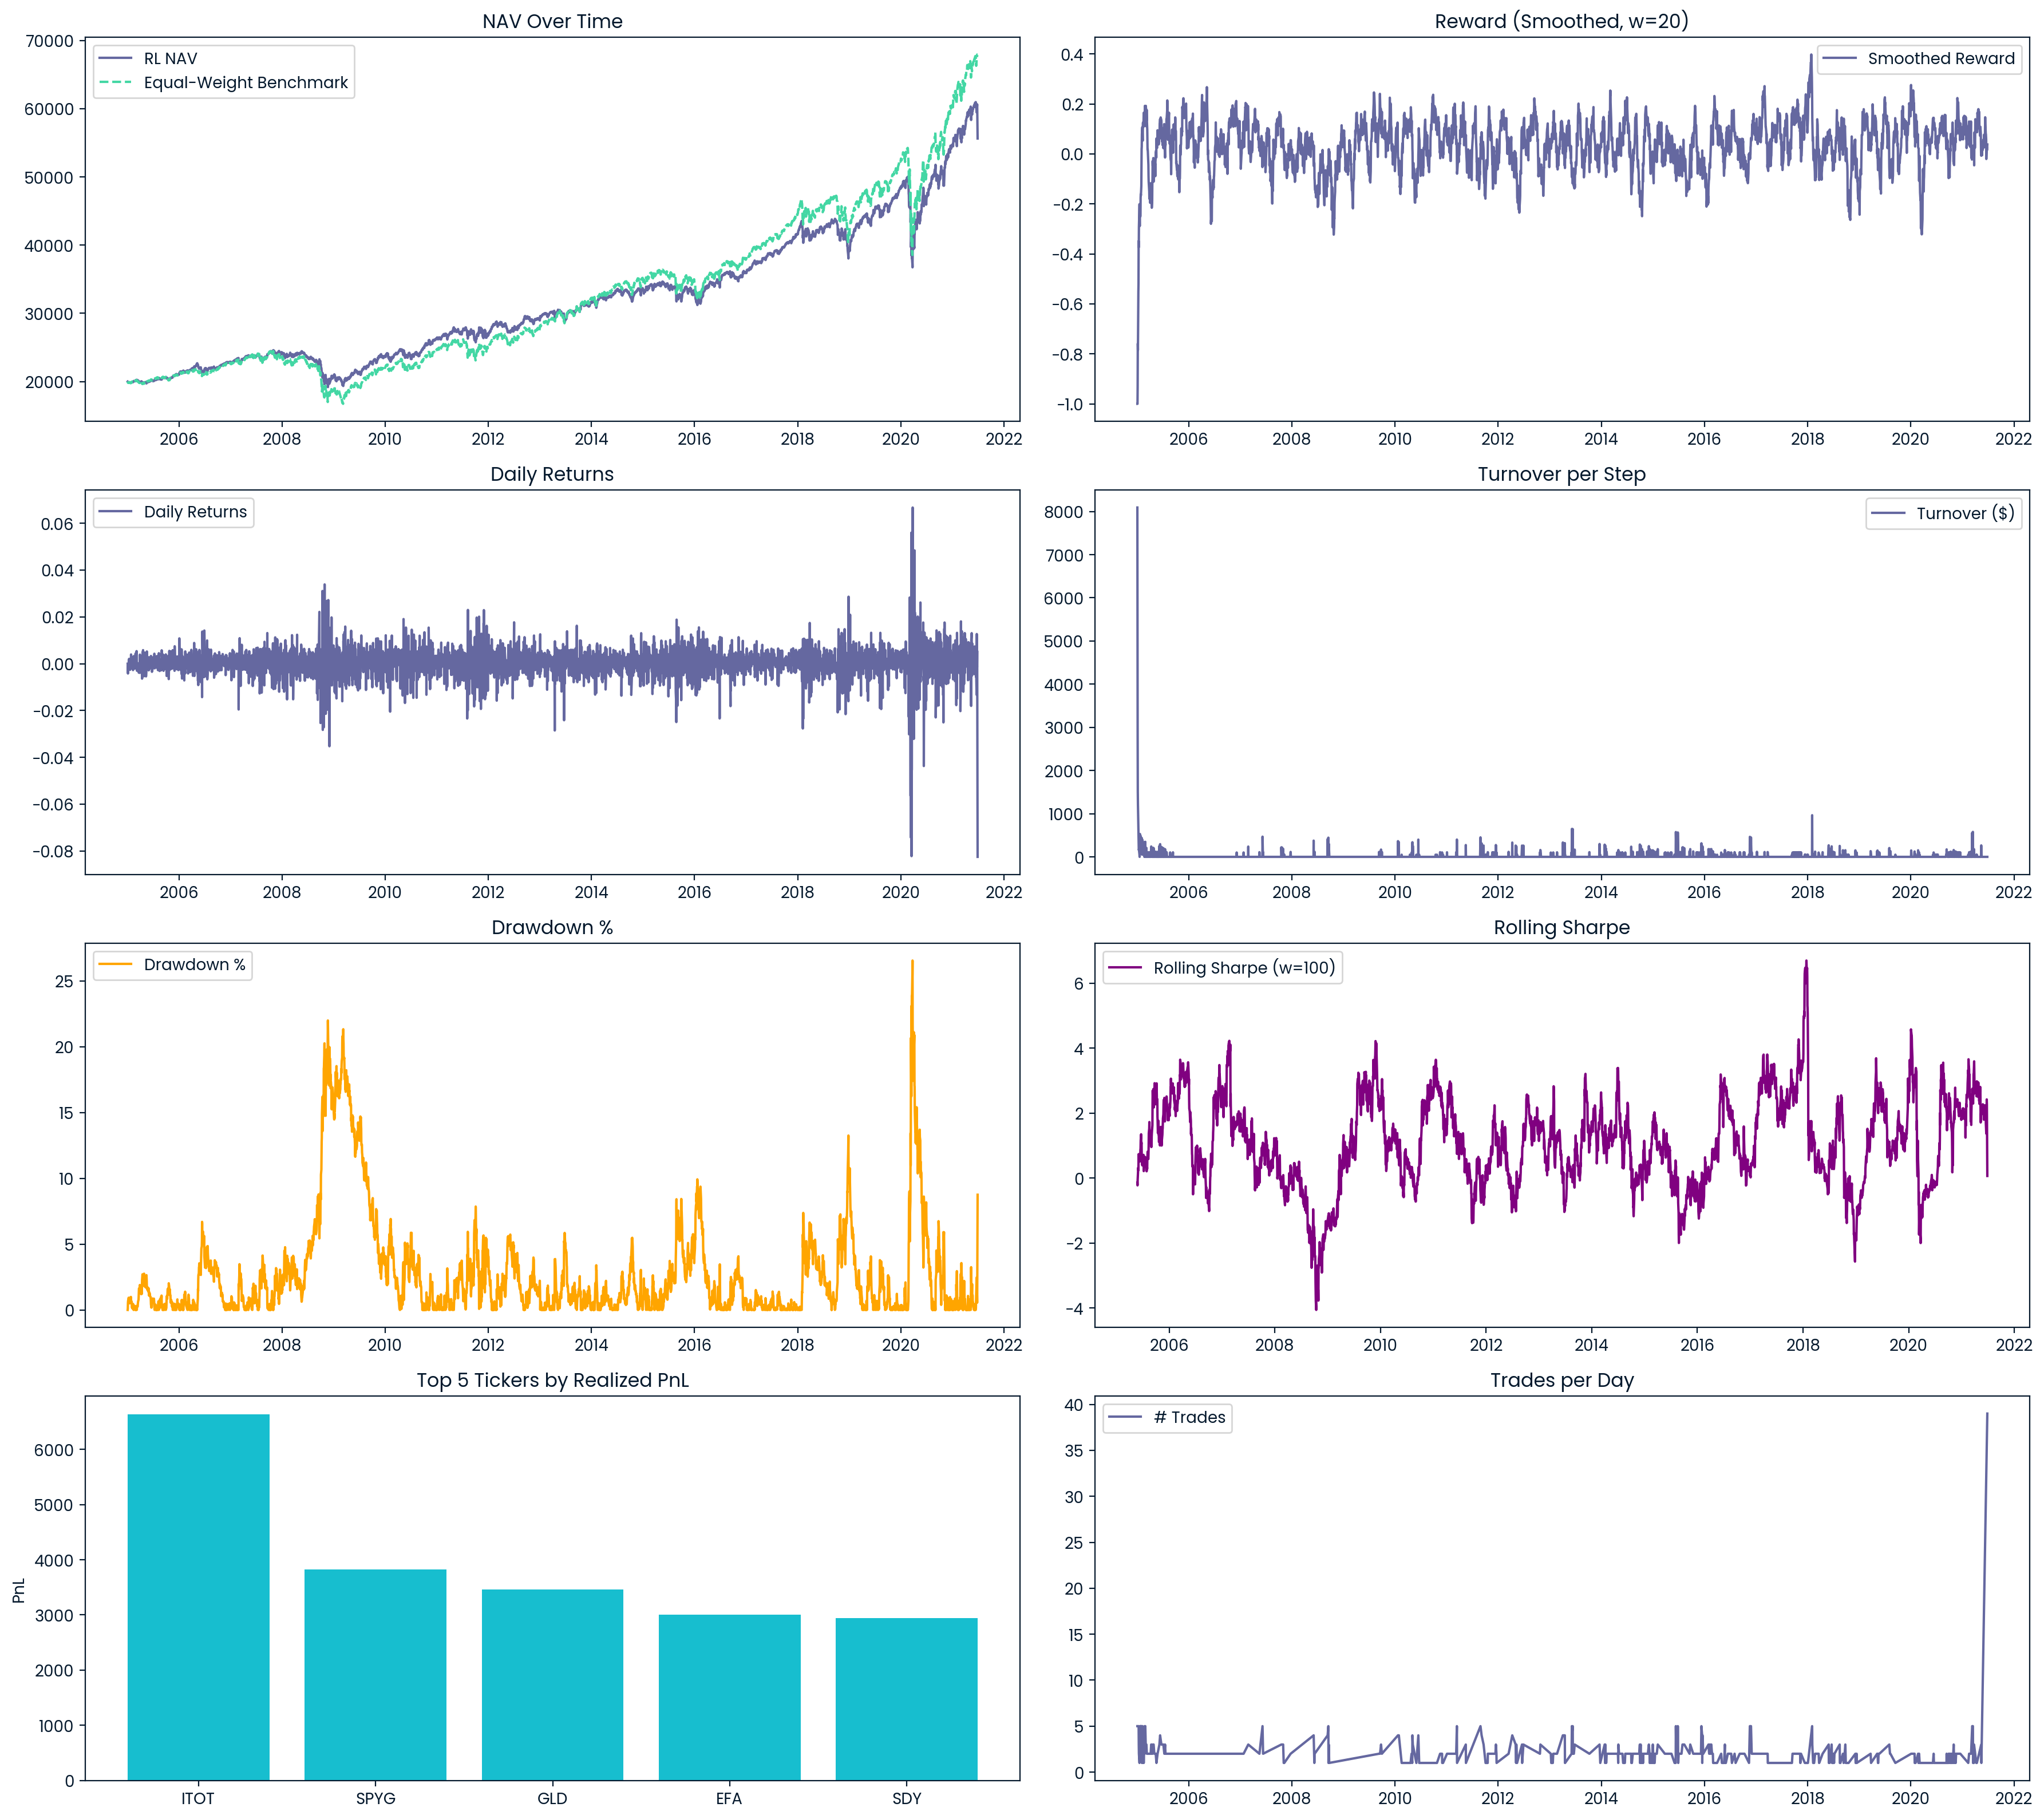

In [29]:
# Train set
train_results = evaluate_trading_bot(model, train_env_eval)

In [30]:
test_env_eval = PortfolioEnvV3(
    stock_data=test_data,
    initial_balance=20000,
    debug=False
)


[eval] episode steps: 1037

=== Evaluation Metrics ===
Final NAV: 25,083.56
CAGR: 0.0565
Sharpe: 0.5966
Max Drawdown %: 17.43
Total Trades: 353


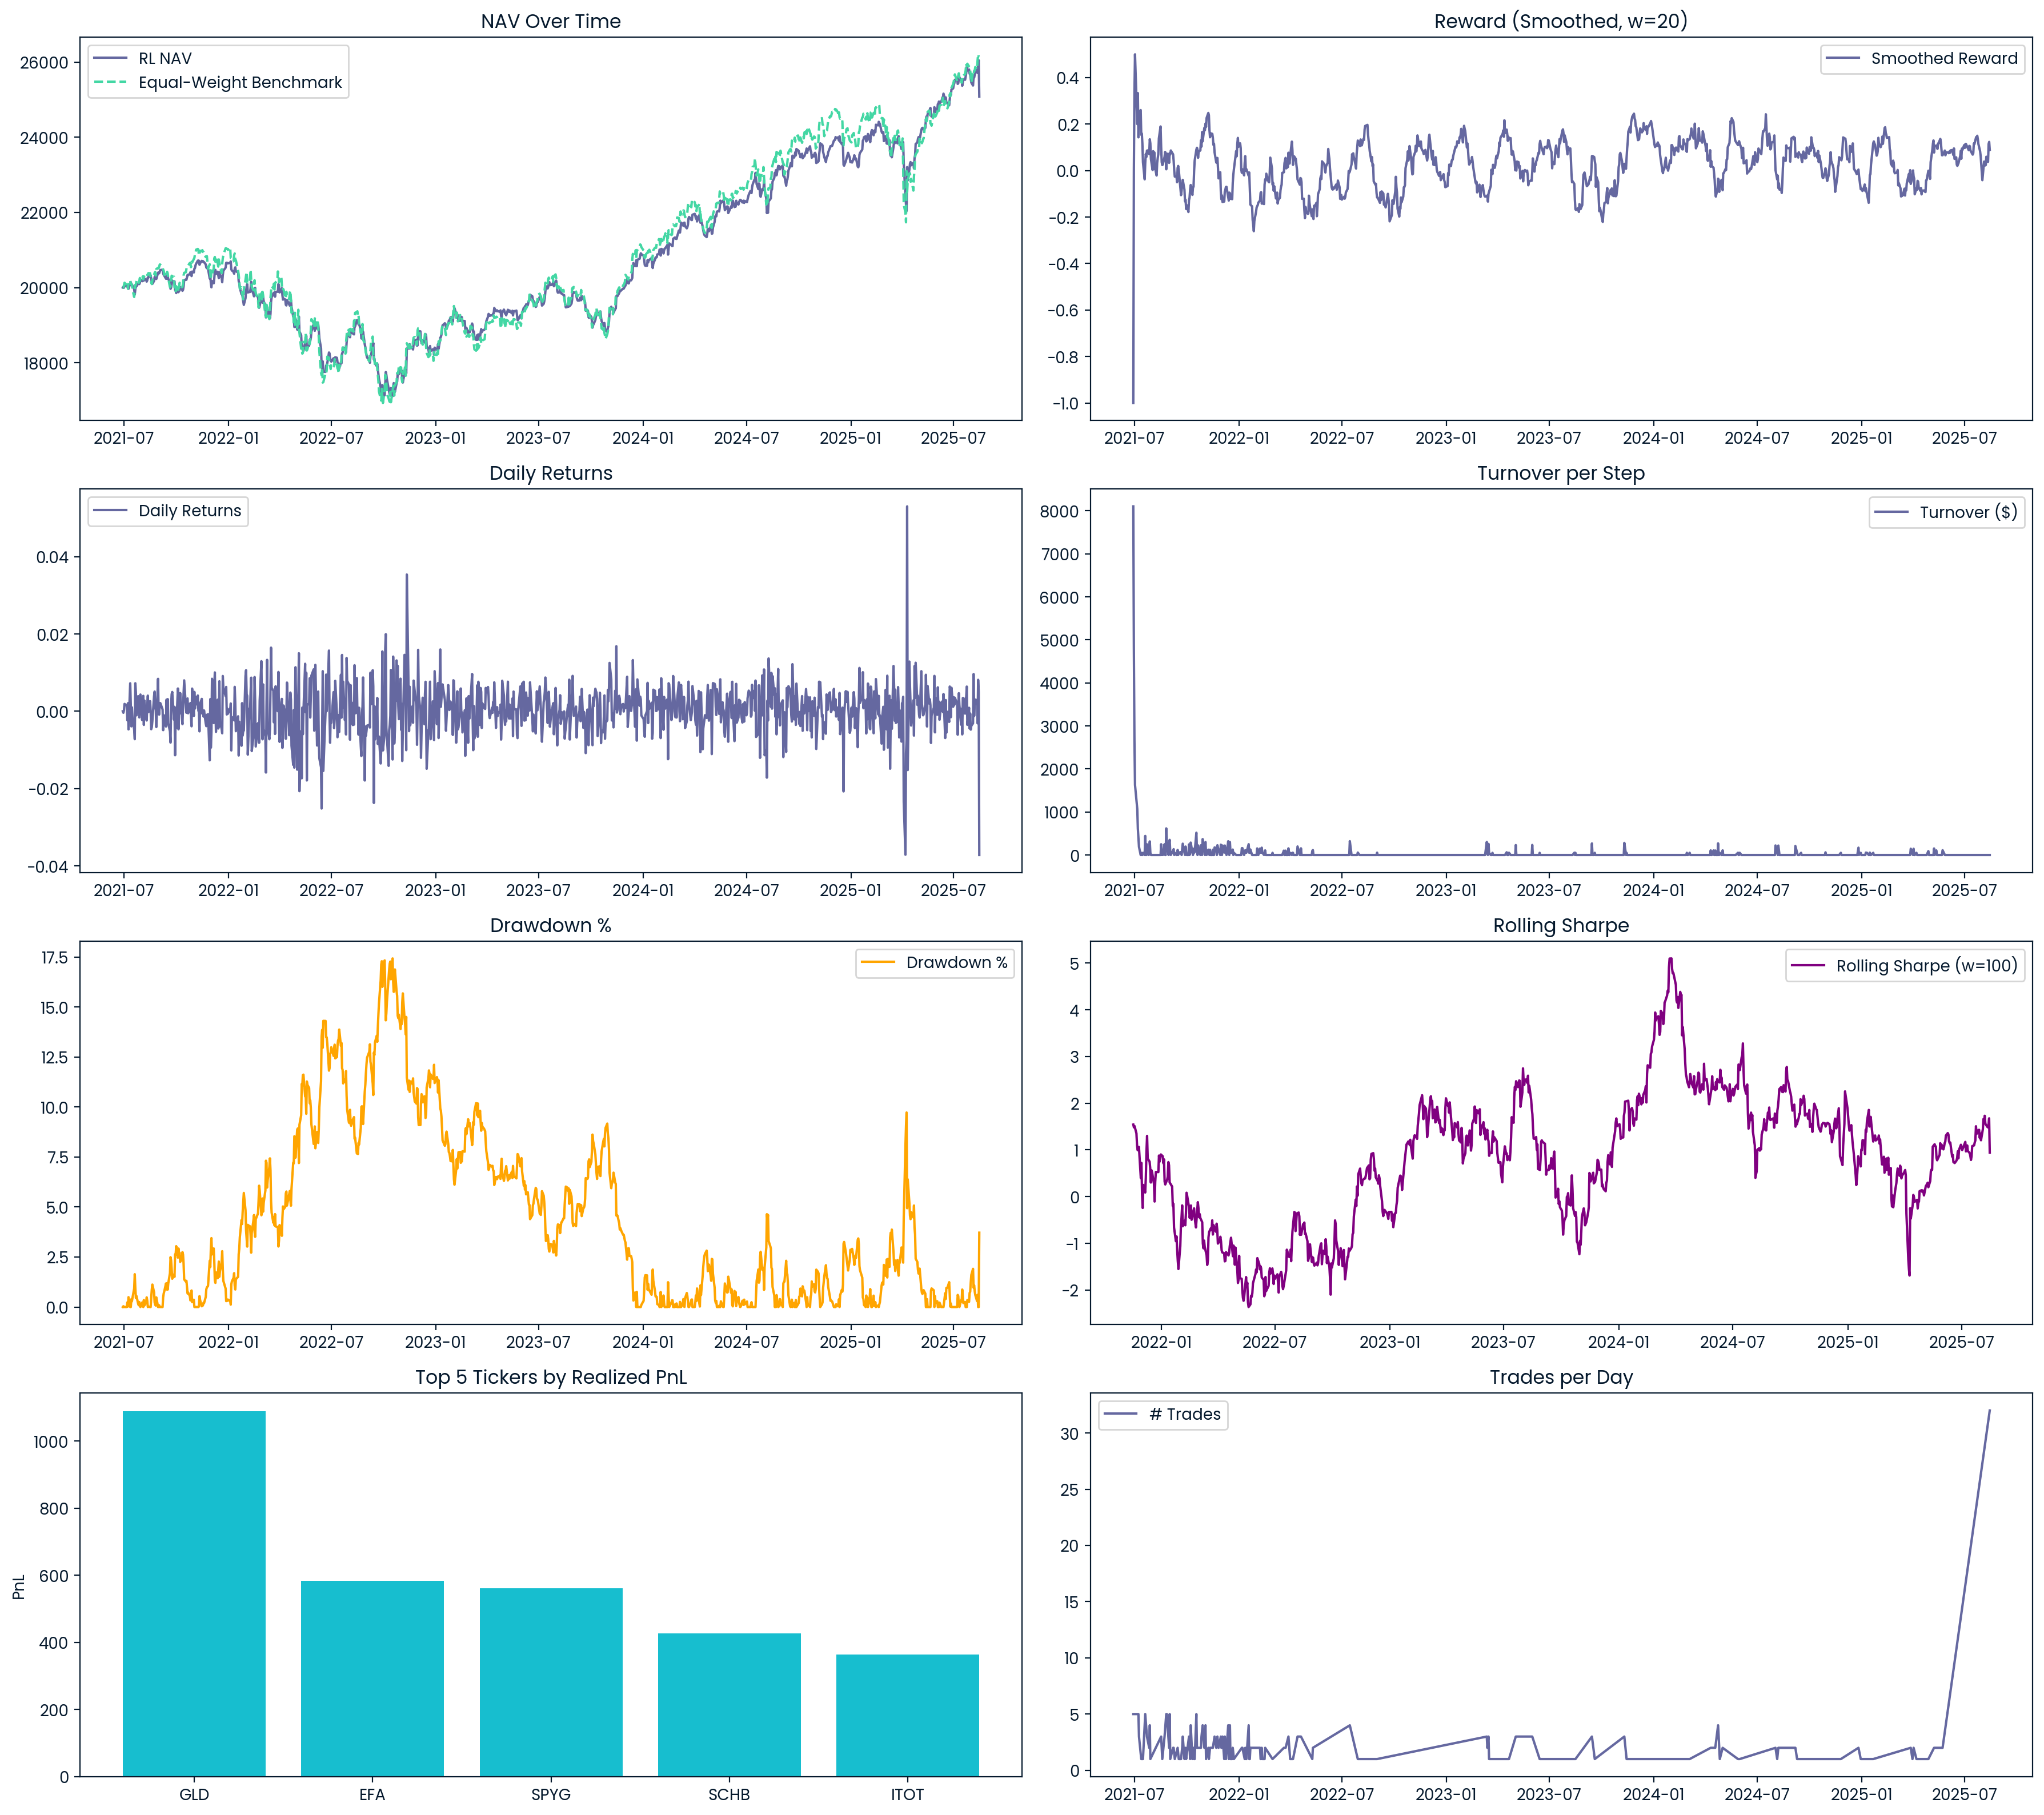

In [31]:
# Test set (you can also pass your previously computed EW series if you prefer)
test_results = evaluate_trading_bot(model, test_env_eval)